# NeuroEvolution of Augmenting Topologies (NEAT)

In this notebook, we will study the use of **NEAT-python framework**. 

- Installation guidelines: <a href='https://neat-python.readthedocs.io/en/latest/installation.html'>here.</a>
- Documentation: <a href='https://neat-python.readthedocs.io/en/latest/neat_overview.html'>here.</a> The section on <a href='https://neat-python.readthedocs.io/en/latest/config_file.html'>configuration files</a> in the NEAT-Python documentation provides especially useful guidance.

<br />

## Imports

In [20]:
import sys
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import torch
import neat
import visualize


## Global settings

In [3]:
seed = 1
device = 'cpu'


<br />

## XOR Data simulation


As we did for Neural Network study, let's run our examples for a very simple non-linear binary classification example.


In [4]:
# Simulate the data
X = 2 * torch.rand(200, 2, device=device, dtype=torch.float32) - 1
y = torch.tensor([0 if elem[0]*elem[1] < 0 else 1 for elem in X], device=device, dtype=torch.float32)
X = X.numpy()
y = y.numpy()

# Split training and test partitions
train_size = 150
X_train = X[:train_size, :]
y_train = y[:train_size]
X_val = X[train_size:, :]
y_val = y[train_size:]

print([X_train.shape, y_train.shape])
print([X_val.shape, y_val.shape])


[(150, 2), (150,)]
[(50, 2), (50,)]


<br />

# NEAT

## Step 1: Configuration file

In NEAT-Python, there are four main components that determine how the algorithm operates:

- **Genome**: Defines the structure and representation of neural network genomes. This class includes methods for initialization, mutation, and crossover of candidate solutions.

- **Reproduction**: Manages the creation of genomes, either from scratch or through sexual/asexual reproduction from parent genomes.

- **Species**: Implements the default speciation (niching) mechanism.

- **Stagnation**: Monitors species' progress and facilitates the removal of stagnant species.

<br />

For each of these components, a corresponding class must be provided to define the algorithm’s behaviour. The NEAT-Python library offers default implementations for these classes, which we will use in this notebook. However, users may also define their own `Genome`, `Reproduction`, `Species`, and `Stagnation` classes to customise or extend the algorithm according to their specific objectives.
<br />

The configuration of each component is specified in a plain-text configuration file. Let’s now explore this configuration file in more detail:

<br />

In [ ]:
config_file = 'config-xor'
with open(config_file, 'r') as f:
    print(f.read())


#--- parameters for the XOR-2 experiment ---#

[NEAT]
fitness_criterion     = max 
#it does not work for minimization
fitness_threshold     = 0.95
pop_size              = 150
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = sigmoid 
#if defined as sigmoid, it will always be sigmoid
activation_mutate_rate  = 0.2
activation_options      = sigmoid gauss relu
#there are a lot of activation functions available, CHECK THE DOCUMENTATION

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options 
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5 
#the std where the new value will come from
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1 
#the rate of replacing the bias with a whole new value

# genome compatibility options
compatibility_disjoint_coeffic

We start by creating the `Config` object, which will use the settings defined in the config text file:


In [ ]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)




print(config.genome_config)
print(type(config.genome_config))
print(type(config))
print(type(config_file))

<class 'neat.genome.DefaultGenomeConfig'>
<class 'neat.config.Config'>
<class 'str'>


In [ ]:
print(config.genome_config)

<br />

## Step 2:  Fitness function

The fitness function is **not** defined in the configuration file. In NEAT-Python, it is considered a hyperparameter of the learning loop and must be implemented manually.

In this notebook, we define the fitness function as the negative sum of squared errors. This is because **NEAT-Python always maximizes fitness values**, so minimising error requires inverting the metric.

When specifying the fitness of individuals, user-defined evaluation metrics can also be incorporated. In this binary classification example, we will additionally compute the accuracy of each individual to monitor classification performance throughout evolution.


In [7]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    return (fit/y.shape[0])**.5

def eval_accuracy(net, X, y):
    '''
    Auxiliary funciton to evaluate the accuracy.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = 1. if net.activate(xi)[0] >= .5 else 0.
        fit += output==xo
    # ACCURACY
    return fit/y.shape[0]

def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments genomes and config.
    -> It has to update the `fitness` attribute of the genome.
    '''
    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Train fitness
        genome.fitness = -eval_rmse(net, X_train, y_train)
        genome.acc = eval_accuracy(net, X_train, y_train)
        # Validation fitness
        genome.fitness_val = -eval_rmse(net, X_val, y_val)
        genome.acc_val = eval_accuracy(net, X_val, y_val)


<br />

## Step 3: Population creation


In [8]:
# Create the population, which is the top-level object for a NEAT run
p = neat.Population(config)


<br />

## Step 4: Run

In [9]:
# Add a stdout reporter to show progress in the terminal
GENERATIONS = 500

p.add_reporter(neat.StdOutReporter(False))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(int(GENERATIONS/3))) #é para adicionar 1 aqui?


In [10]:
# Run until threshold or up to max generations
with open('output_xor.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    try:
        winner = p.run(eval_genomes, GENERATIONS)
    finally:
        sys.stdout = original_stdout


The NN solution retruned by NEAT:

In [34]:
print(str(winner)) #key is the innovation number

Key: 60086
Fitness: -0.23318310145263893
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.12315704566285324, response=0.6192182763472756, activation=gauss, aggregation=sum)
	277 DefaultNodeGene(key=277, bias=-0.44353713505770564, response=4.116765313617441, activation=sigmoid, aggregation=sum)
	366 DefaultNodeGene(key=366, bias=-0.05622009606477796, response=-3.9114559259756145, activation=relu, aggregation=sum)
	495 DefaultNodeGene(key=495, bias=-0.3604473159946912, response=3.288536428475698, activation=gauss, aggregation=sum)
	737 DefaultNodeGene(key=737, bias=1.2929076170245062, response=0.5362250652005278, activation=relu, aggregation=sum)
	3755 DefaultNodeGene(key=3755, bias=0.19390416151933448, response=-1.3081742580138973, activation=sigmoid, aggregation=sum)
	3860 DefaultNodeGene(key=3860, bias=-1.40306099792177, response=-0.7093333392009582, activation=sigmoid, aggregation=sum)
	5142 DefaultNodeGene(key=5142, bias=-0.07539777096963052, response=-1.22779203068729, activation=sigmoid, 

In [17]:
node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=False)
# 'solid' if cg.enabled else 'dotted'
# 'green' if cg.weight > 0 else 'red'


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [23]:
# Show output of the most fit genome against training data.
print('\nOutput:')

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(X_train[:3, :], y_train[:3]):
    output = winner_net.activate(xi)
    print('  expected output {!r}, got {!r}'.format(xo, output))
    
out = []
for xi, xo in zip(X_train, y_train):
    output = winner_net.activate(xi)
    out.append(output[0])
    


Output:
  expected output 1.0, got [0.9936132445324501]
  expected output 1.0, got [0.9918103975214722]
  expected output 0.0, got [0.004365969292676167]


In [14]:
torch.sqrt(torch.mean((torch.tensor(out)-y_train)**2))

tensor(0.0719)

In [15]:
res = torch.tensor(out) >=.5
torch.mean(res.double())


tensor(0.4200, dtype=torch.float64)

In [16]:
p.generation

500

## Plotting algorithm evolution

In [17]:
# dir(stats)
# 'best_genome',
#  'best_genomes',
#  'best_unique_genomes',
#  'complete_extinction',
#  'end_generation',
#  'found_solution',
#  'generation_statistics',
#  'get_average_cross_validation_fitness',
#  'get_fitness_mean',
#  'get_fitness_median',
#  'get_fitness_stat',
#  'get_fitness_stdev',
#  'get_species_fitness',
#  'get_species_sizes',
#  'info',
#  'most_fit_genomes',
#  'post_evaluate',
#  'post_reproduction',
#  'save',
#  'save_genome_fitness',
#  'save_species_count',
#  'save_species_fitness',
#  'species_stagnant',
#  'start_generation']

len(stats.generation_statistics)
print(stats.get_fitness_stat(max)[:20])


[-0.49828958057722467, -0.49828958057722467, -0.47333255298226523, -0.47333255298226523, -0.4691094357180076, -0.3896910437375626, -0.3833597111103243, -0.3833597111103243, -0.3833597111103243, -0.3833597111103243, -0.3833597111103243, -0.3833597111103243, -0.35405688421693227, -0.3539064327716184, -0.3539064327716184, -0.3539064327716184, -0.34779711808578295, -0.34779711808578295, -0.34779711808578295, -0.34507068603394214]



Accuracy: [0.9933333333333333, 1.0]



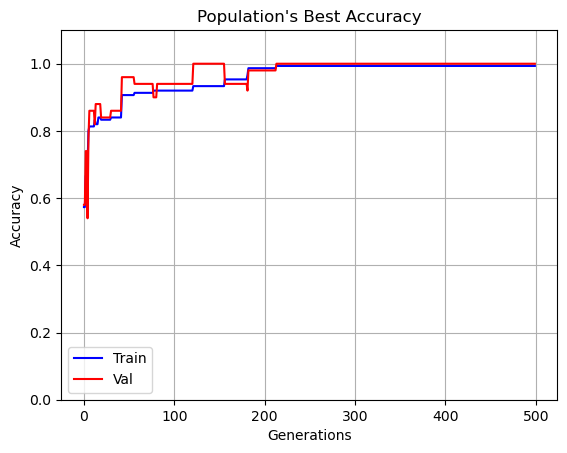

In [18]:
print('\nAccuracy: {}\n'.format([winner.acc, winner.acc_val]))
visualize.plot_stats_metrics(stats, metric='acc', metric_name='Accuracy', ylog=False, view=True, y_max=1.1)


RMSE: [-0.07193114584391289, -0.005649138907774771]


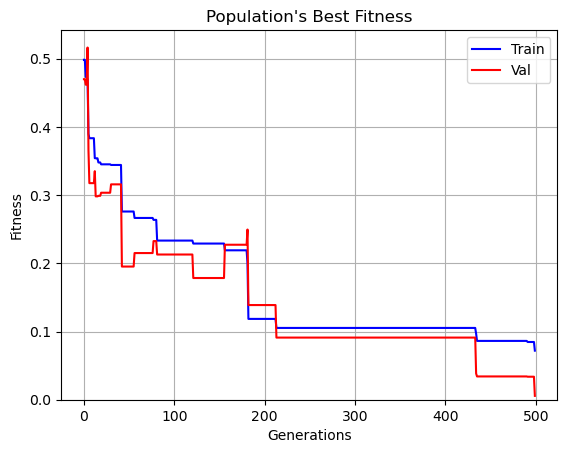

In [19]:
print('RMSE: {}'.format([winner.fitness, winner.fitness_val]))
visualize.plot_stats(stats, ylog=False, show_pop=False, invert_y=True, view=True)


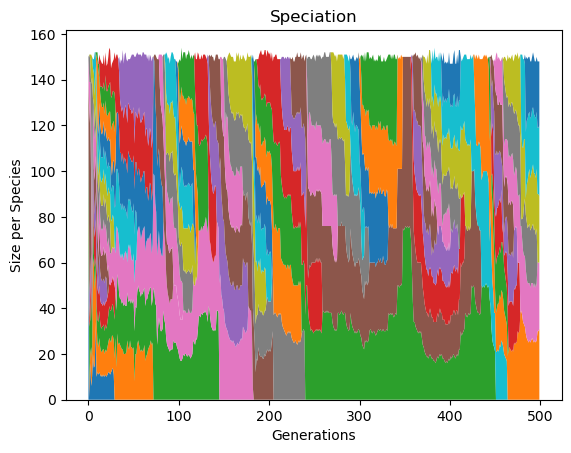

In [20]:
visualize.plot_species(stats, view=True)

we can see that we have diversity

each of the colors is proportional to the number of individuals in a species.

Red one was extinguished? but there is no problem we have many others.

